# Utilizing EquiBind for In-Silico Selection of Anti-Cancer Drug Candidates 
### Andrew Smith
--------------

In [1]:
# Required Imports
import os
import re
import random
import subprocess
import threading
from collections import defaultdict

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, SDWriter, SDMolSupplier

import matplotlib.pyplot as plt
import pandas as pd
import py3Dmol

%config InlineBackend.figure_format='retina'

# Define Config Vars
NUM_THREADS = os.cpu_count()
BATCH_SIZE = 128

## The Equibind Model
EquiBind is a groundbreaking SE(3)-equivariant geometric deep learning model that predicts protein-ligand binding structures rapidly and accurately. One of the core components of EquiBind is the Independent E(3)-Equivariant Graph Matching Network (IEGMN), which plays a crucial role in learning complex molecular interactions while preserving equivariance under rigid transformations.

In the context of drug discovery, protein-ligand binding refers to the interaction between a protein (receptor) and a small molecule (ligand). Predicting the binding structure is vital for understanding the potential effects of drugs on their target proteins.

IEGMN is a graph neural network that jointly transforms both features (molecular properties) and 3D coordinates (spatial information) to perform intra (within a molecule) and inter (between molecules) neural graph message passing. Its architecture guarantees that any independent rotation and translation of the input structures are precisely reflected in the outputs, making it an effective tool for analyzing molecular structures. In practice, the outputs are obtained by stacking several IEGMN layers.

To identify the rigid SE(3) transformation (a combination of rotation and translation) required to dock the ligand in the correct position and orientation, EquiBind employs an SE(3)-equivariant multi-head attention mechanism. This mechanism computes ligand and receptor keypoints, which are critical points on the molecular surface that help guide the alignment of the molecules.

These keypoints are trained to match the ground truth binding pocket points (the actual positions of the molecules in their bound state) using an optimal transport loss that recovers their alignment. When the ligand and receptor are separated, the model identifies the corresponding binding sites and their exact matching using the two predicted keypoint sets. If predicted perfectly, the SE(3) transformation to superimpose these sets would precisely correspond to the binding SE(3) transformation required for ligand docking.

----------
## The RAS Protein
The Ras protein plays a critical role in regulating cell growth, and mutations in the Ras gene have been linked to cancer. Therefore, discovering molecules that can dock and form complexes with Ras is essential because it could lead to the development of new treatments for cancer. By targeting Ras and disrupting its activity, it may be possible to limit the uncontrolled growth of cancer cells. Additionally, understanding the structure and function of Ras and its interactions with other proteins in the signaling network could lead to a better understanding of the mechanisms that regulate cell growth and division, which could have implications for developing treatments for other diseases.

The PDB file required for this notebook is available [here](https://www.rcsb.org/structure/5p21). Make sure to download it and add it to `data/ras/ras_protein.pdb`.

In [2]:
pdb_file = 'data/ras/ras_protein.pdb'

with open(pdb_file, 'r') as f:
    pdb_data = f.read()

view = py3Dmol.view(width=700, height=700)
view.addModel(pdb_data, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

--------
## Inference: Multiple Ligands w/ Single Protein

In [3]:
# Download copy of zinc250k from github
url = 'https://raw.githubusercontent.com/divelab/DIG_storage/main/ggraph/zinc250k_property.csv'
df = pd.read_csv(url)
smiles = df['smile']

In [4]:
df.head()

,qed,penalized_logp,smile
0,0.731901,3.139906,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
1,0.941112,0.172386,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
2,0.626105,2.618423,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
3,0.716225,-1.974847,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...
4,0.809572,-0.205555,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...


### Process the Data
While EquiBind comes with a preprocessed dataset that consists of tens of thousands of ligand and protein combinations, the Zinc250k dataset only consisted of SMILES strings. In the code cell directly below I was able to convert the strings to RDKit Molecule objects adding explicit hydrogens per the requirements of the model. 

In [5]:
def process_smiles(smi):
    """
    Converts a SMILES string to a 3D molecule object.

    Args:
    - smi (str): The SMILES string to convert.

    Returns:
    - An RDKit 3D molecule object, or None if the SMILES string could not be converted.
    """
    try:
        mol = Chem.MolFromSmiles(smi)
        mol = Chem.AddHs(mol)  # Add explicit Hs
        AllChem.EmbedMolecule(mol)
        return mol
    except:
        # Skip if unrecognized charge state or similar
        return None

# Create a list of threads to process SMILES strings
threads = []
molecules = [None] * len(smiles)
for i, smi in enumerate(smiles):
    t = threading.Thread(
        target=lambda index, smi: molecules.__setitem__(index, process_smiles(smi)), args=(i, smi)
    )
    t.start()
    threads.append(t)

# Wait for threads to finish
for t in threads:
    t.join()

# Write molecules to SDF file
writer = Chem.SDWriter('molecules.sdf')
for mol in molecules:
    writer.write(mol)
writer.close()

[13:35:18] UFFTYPER: Unrecognized charge state for atom: 5
[13:35:22] UFFTYPER: Unrecognized charge state for atom: 6
[13:38:14] UFFTYPER: Unrecognized charge state for atom: 2
[13:39:02] UFFTYPER: Unrecognized charge state for atom: 18
[13:39:21] UFFTYPER: Warning: hybridization set to SP3 for atom 7
[13:39:47] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[13:40:47] UFFTYPER: Unrecognized charge state for atom: 1
[13:42:38] UFFTYPER: Unrecognized charge state for atom: 17
[13:42:43] UFFTYPER: Unrecognized charge state for atom: 18


--------------
### Changes to EquiBind
There were several issues that came up while trying to use the existing model to perform inference. In order to get around this, several changes to the code base had to be done. Here are the specific changes and the files that were modified.


>`commons/process_mols.py`
>
>Update the lig_atom_featurizer so that it will skip atoms with unknown chiral tags by setting their feature vector to all zeros.
>
>```python
>def lig_atom_featurizer(mol):
>    ComputeGasteigerCharges(mol)
>    ringinfo = mol.GetRingInfo()
>    atom_features_list = []
>    for idx, atom in enumerate(mol.GetAtoms()):
>        g_charge = atom.GetDoubleProp('_GasteigerCharge')
>        chiral_tag_index = safe_index(allowable_features['possible_chirality_list'], str(atom.GetChiralTag()))
>
>        if chiral_tag_index != -1:
>            atom_features_list.append([
>                safe_index(allowable_features['possible_atomic_num_list'], atom.GetAtomicNum()),
>                chiral_tag_index,
>                safe_index(allowable_features['possible_degree_list'], atom.GetTotalDegree()),
>                safe_index(allowable_features['possible_formal_charge_list'], atom.GetFormalCharge()),
>                safe_index(allowable_features['possible_implicit_valence_list'], atom.GetImplicitValence()),
>                safe_index(allowable_features['possible_numH_list'], atom.GetTotalNumHs()),
>                safe_index(allowable_features['possible_number_radical_e_list'], atom.GetNumRadicalElectrons()),
>                safe_index(allowable_features['possible_hybridization_list'], str(atom.GetHybridization())),
>                allowable_features['possible_is_aromatic_list'].index(atom.GetIsAromatic()),
>                safe_index(allowable_features['possible_numring_list'], ringinfo.NumAtomRings(idx)),
>                allowable_features['possible_is_in_ring3_list'].index(ringinfo.IsAtomInRingOfSize(idx, 3)),
>                allowable_features['possible_is_in_ring4_list'].index(ringinfo.IsAtomInRingOfSize(idx, 4)),
>                allowable_features['possible_is_in_ring5_list'].index(ringinfo.IsAtomInRingOfSize(idx, 5)),
>                allowable_features['possible_is_in_ring6_list'].index(ringinfo.IsAtomInRingOfSize(idx, 6)),
>                allowable_features['possible_is_in_ring7_list'].index(ringinfo.IsAtomInRingOfSize(idx, 7)),
>                allowable_features['possible_is_in_ring8_list'].index(ringinfo.IsAtomInRingOfSize(idx, 8)),
>                g_charge if not np.isnan(g_charge) and not np.isinf(g_charge) else 0.
>            ])
>        else:
>            atom_features_list.append([0] * 17)
>
>    return torch.tensor(atom_features_list)
>```

<br>

>`commons/geometry_utils.py`
>
> When performing SVD in the rigid_transform_Kabsch_3D calculation, it was common for certain molecules to fail to converge. Thus, I had to add error handling when finding the rotation. If Numpy's SVD function failed to converge, I would skip the molecule.
>```python
>def rigid_transform_Kabsch_3D(A, B):
>    assert A.shape[1] == B.shape[1]
>    num_rows, num_cols = A.shape
>    if num_rows != 3:
>        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")
>    num_rows, num_cols = B.shape
>    if num_rows != 3:
>        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")
>
>    # find mean column wise: 3 x 1
>    centroid_A = np.mean(A, axis=1, keepdims=True)
>    centroid_B = np.mean(B, axis=1, keepdims=True)
>
>    # subtract mean
>    Am = A - centroid_A
>    Bm = B - centroid_B
>
>    H = Am @ Bm.T
>
>    # find rotation
>    try:
>        U, S, Vt = np.linalg.svd(H)
>    except np.linalg.LinAlgError:
>        # Handle the error here, e.g., return None or a special value
>        return None, None
>
>    R = Vt.T @ U.T
>
>    # special reflection case
>    if np.linalg.det(R) < 0:
>        # print("det(R) < R, reflection detected!, correcting for it ...")
>        SS = np.diag([1.,1.,-1.])
>        R = (Vt.T @ SS) @ U.T
>    assert math.fabs(np.linalg.det(R) - 1) < 1e-5
>
>    t = -R @ centroid_A + centroid_B
>    return R, t
>```

<br>

>`multiligand_inference.py`
>The modifications above result in None types being returned when a convergence or molecule issue arises. Thus, two additional functions in the main script had to be updated to process None types.
>```python
> def run_corrections(lig, lig_coord, ligs_coords_pred_untuned):
>     input_coords = lig_coord.detach().cpu()
>     prediction = ligs_coords_pred_untuned.detach().cpu()
>     lig_input = deepcopy(lig)
>     conf = lig_input.GetConformer()
>     for i in range(lig_input.GetNumAtoms()):
>         x, y, z = input_coords.numpy()[i]
>         conf.SetAtomPosition(i, Point3D(float(x), float(y), float(z)))
>
>     lig_equibind = deepcopy(lig)
>     conf = lig_equibind.GetConformer()
>     for i in range(lig_equibind.GetNumAtoms()):
>         x, y, z = prediction.numpy()[i]
>         conf.SetAtomPosition(i, Point3D(float(x), float(y), float(z)))
>
>     coords_pred = lig_equibind.GetConformer().GetPositions()
>
>     Z_pt_cloud = coords_pred
>     rotable_bonds = get_torsions([lig_input])
>     new_dihedrals = np.zeros(len(rotable_bonds))
>     for idx, r in enumerate(rotable_bonds):
>         new_dihedrals[idx] = get_dihedral_vonMises(lig_input, lig_input.GetConformer(), r, Z_pt_cloud)
>     optimized_mol = apply_changes(lig_input, new_dihedrals, rotable_bonds)
>     optimized_conf = optimized_mol.GetConformer()
>     coords_pred_optimized = optimized_conf.GetPositions()
>     
>     ####################### ADD THIS ##########################
>     R, t = rigid_transform_Kabsch_3D(coords_pred_optimized.T, coords_pred.T)
>     if R is None or t is None:
>         # Handle the situation when SVD doesn't converge, e.g., skip this case
>         return None
>     ###########################################################
>     
>     coords_pred_optimized = (R @ (coords_pred_optimized).T).T + t.squeeze()
>     for i in range(optimized_mol.GetNumAtoms()):
>         x, y, z = coords_pred_optimized[i]
>         optimized_conf.SetAtomPosition(i, Point3D(float(x), float(y), float(z)))
>     return optimized_mol
>
> def write_while_inferring(dataloader, model, args):
>     
>     full_output_path = os.path.join(args.output_directory, "output.sdf")
>     full_failed_path = os.path.join(args.output_directory, "failed.txt")
>     full_success_path = os.path.join(args.output_directory, "success.txt")
>
>     w_or_a = "a" if args.skip_in_output else "w"
>     with torch.no_grad(), open(full_output_path, w_or_a) as file, open(
>         full_failed_path, "a") as failed_file, open(full_success_path, w_or_a) as success_file:
>         with Chem.SDWriter(file) as writer:
>             i = 0
>             total_ligs = len(dataloader.dataset)
>             for batch in dataloader:
>                 i += args.batch_size
>                 if i % 1000 == 0:
>                     print(f"Entering batch ending in index {min(i, total_ligs)}/{len(dataloader.dataset)}")
>                 ligs, lig_coords, lig_graphs, rec_graphs, geometry_graphs, true_indices, failed_in_batch = batch
>                 for failure in failed_in_batch:
>                     if failure[1] == "Skipped":
>                        continue
>                    failed_file.write(f"{failure[0]} {failure[1]}")
>                    failed_file.write("\n")
>                if ligs is None:
>                    continue
>                lig_graphs = lig_graphs.to(args.device)
>                rec_graphs = rec_graphs.to(args.device)
>                geometry_graphs = geometry_graphs.to(args.device)
>
>                out_ligs, out_lig_coords, predictions, successes, failures = run_batch(
>                    model, ligs, lig_coords, lig_graphs, 
>                    rec_graphs, geometry_graphs, true_indices,
>                )
>
>                ####################### MODIFY THIS ##########################
>                opt_mols = []
>                for lig, lig_coord, prediction in zip(
>                    out_ligs, out_lig_coords, predictions
>                ):
>                    opt_mol = run_corrections(lig, lig_coord, prediction)
>                    if opt_mol is not None:
>                       opt_mols.append(opt_mol)
>              ##############################################################
>
>                for mol, success in zip(opt_mols, successes):
>                    writer.write(mol)
>                    success_file.write(f"{success[0]} {success[1]}")
>                    success_file.write("\n")
>                for failure in failures:
>                    failed_file.write(f"{failure[0]} {failure[1]}")
>                    failed_file.write("\n")
>```                

-----------
### Execute Equibind

In [6]:
!python multiligand_inference.py -o data/output/ -r data/ras/ras_protein.pdb -l molecules.sdf --batch_size $BATCH_SIZE

[2023-05-08 13:43:42.302639] [ Using Seed :  1  ]
Found 249455 previously calculated ligands
device = cuda:0


------------

### Inspection Functions
After using the multiligand_inference.py script that comes with the equibind model to infer potential ligands for the RAS protein from the Zinc250k dataset, I was provided with an output.sdf file that appeared to consist of the same number of molecules that I input. This observation was perplexing, and to better understand what was happening, I had to develop various functions to examine the contents of the output.sdf file. These functions were necessary to inspect the molecular positions of each atom in the ligand. 

In [7]:
def count_molecules_in_chunk(sdf_file, start, end):
    """
    Counts the number of molecules in a chunk of an SDF file.

    Args:
    - sdf_file (str): The path to the SDF file.
    - start (int): The index of the first molecule in the chunk.
    - end (int): The index of the last molecule in the chunk (exclusive).

    Returns:
    - The number of molecules in the chunk.
    """
    sdf_supplier = Chem.SDMolSupplier(sdf_file)
    count = 0
    for i in range(start, end):
        mol = sdf_supplier[i]
        if mol is not None:
            count += 1
    return count

def count_molecules(sdf_file, num_processes):
    """
    Counts the total number of molecules in an SDF file, using multiple processes.

    Args:
    - sdf_file (str): The path to the SDF file.
    - num_processes (int): The number of processes to use.

    Returns:
    - The total number of molecules in the SDF file.
    """
    sdf_supplier = Chem.SDMolSupplier(sdf_file)
    total_molecules = len(sdf_supplier)

    chunk_size = total_molecules // num_processes
    chunks = [(i * chunk_size, (i + 1) * chunk_size) for i in range(num_processes - 1)]
    chunks.append(((num_processes - 1) * chunk_size, total_molecules))

    molecule_count = 0

    with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
        futures = [executor.submit(count_molecules_in_chunk, sdf_file, start, end) for start, end in chunks]
        for future in concurrent.futures.as_completed(futures):
            molecule_count += future.result()

    return molecule_count

def mol_to_smiles(mol):
    """
    Converts a molecule object to a SMILES string.

    Args:
    - mol (rdkit.Chem.rdchem.Mol): The molecule object to convert.

    Returns:
    - A SMILES string representing the molecule.
    """
    return Chem.MolToSmiles(mol) if mol is not None else None

def sdf_to_smiles_set(sdf_file, num_threads=os.cpu_count()):
    """
    Converts an SDF file to a set of unique SMILES strings, using multiple threads.

    Args:
    - sdf_file (str): The path to the SDF file.
    - num_threads (int): The number of threads to use (default is the number of CPU cores).

    Returns:
    - A set containing the unique SMILES strings in the SDF file.
    """
    sdf_supplier = Chem.SDMolSupplier(sdf_file)
    mols = [mol for mol in sdf_supplier]

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        smiles_list = list(executor.map(mol_to_smiles, mols))

    return set(smiles_list)

def compare_sdf_files(sdf_file1, sdf_file2):
    """
    Compares the molecules in two SDF files and reports the differences.

    Args:
    - sdf_file1 (str): The path to the first SDF file.
    - sdf_file2 (str): The path to the second SDF file.

    Returns:
    - None. Prints a message indicating the differences between the files.
    """
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        smiles_set1_future = executor.submit(sdf_to_smiles_set, sdf_file1)
        smiles_set2_future = executor.submit(sdf_to_smiles_set, sdf_file2)

        smiles_set1 = smiles_set1_future.result()
        smiles_set2 = smiles_set2_future.result()

    difference1 = smiles_set1.difference(smiles_set2)
    difference2 = smiles_set2.difference(smiles_set1)

    if not difference1 and not difference2:
        print("The two SDF files are identical.")
    else:
        print(f"Number of Molecules in {sdf_file1} not found in {sdf_file2}: {len(difference1)}")
        print(f"Number of Molecules in {sdf_file2} not found in {sdf_file1}: {len(difference2)}")
        
def process_molecule(mol, x_freq, y_freq, z_freq):
    """
    Processes the input molecule and extracts the x, y, and z coordinates of each atom. 
    Updates the frequency dictionaries for each coordinate with the counts of atoms at that coordinate.

    Args:
    - mol (rdkit.Chem.rdchem.Mol): the input molecule to be processed
    - x_freq (collections.defaultdict): a defaultdict representing the frequency of atoms at each x coordinate
    - y_freq (collections.defaultdict): a defaultdict representing the frequency of atoms at each y coordinate
    - z_freq (collections.defaultdict): a defaultdict representing the frequency of atoms at each z coordinate

    Returns:
    - None
    """
    if mol is None:
        return

    conf = mol.GetConformer()
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        x, y, z = pos.x, pos.y, pos.z

        x_freq[round(x)] += 1
        y_freq[round(y)] += 1
        z_freq[round(z)] += 1

def process_sdf(sdf_file):
    """
    Processes an SDF file and extracts the frequency of atoms at each x, y, and z coordinate.
    Uses a ThreadPoolExecutor to parallelize the processing of each molecule in the SDF file.

    Args:
    - sdf_file (str): the path to the SDF file to be processed

    Returns:
    - x_freq (collections.defaultdict): a defaultdict representing the frequency of atoms at each x coordinate
    - y_freq (collections.defaultdict): a defaultdict representing the frequency of atoms at each y coordinate
    - z_freq (collections.defaultdict): a defaultdict representing the frequency of atoms at each z coordinate
    """
    suppl = Chem.SDMolSupplier(sdf_file)
    molecules = [mol for mol in suppl if mol is not None]

    x_freq = defaultdict(int)
    y_freq = defaultdict(int)
    z_freq = defaultdict(int)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_molecule, mol, x_freq, y_freq, z_freq) for mol in molecules]
        concurrent.futures.wait(futures)
    
    return x_freq, y_freq, z_freq

def plot_frequency(freq_dicts, title, ax):
    """
    Plots the frequency of atoms at each x, y, and z coordinate for a list of frequency dictionaries.

    Args:
    - freq_dicts (list): a list of defaultdicts representing the frequency of atoms at each coordinate.
    - title (str): the title of the plot.
    - ax (matplotlib.axes._subplots.AxesSubplot): the axes to plot on.

    Returns:
    - None
    """
    colors = ['blue', 'green', 'red']
    labels = ['X', 'Y', 'Z']
    
    for freq_dict, color, label in zip(freq_dicts, colors, labels):
        keys = sorted(freq_dict.keys())
        values = [freq_dict[key] for key in keys]
        ax.bar(keys, values, color=color, alpha=0.5, label=label)

    ax.set_xlabel('Coordinate')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()

def plot_sdf_files(sdf_file1, sdf_file2):
    """
    Compares the frequency of atoms at each x, y, and z coordinate for two SDF files.
    Plots the frequency distributions for each coordinate side by side.

    Args:
    - sdf_file1 (str): the path to the first SDF file.
    - sdf_file2 (str): the path to the second SDF file.

    Returns:
    - None
    """
    x_freq1, y_freq1, z_freq1 = process_sdf(sdf_file1)
    x_freq2, y_freq2, z_freq2 = process_sdf(sdf_file2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    
    plot_frequency([x_freq1, y_freq1, z_freq1], 'File 1: Frequency of X, Y, Z Coordinates', ax1)
    plot_frequency([x_freq2, y_freq2, z_freq2], 'File 2: Frequency of X, Y, Z Coordinates', ax2)

    plt.show()

In [8]:
sdf_file1 = 'molecules.sdf'
print(f"The number of molecules in {sdf_file1} is {count_molecules(sdf_file1, NUM_THREADS)}")

[13:43:52] Conflicting single bond directions around double bond at index 1.
[13:43:52]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13:43:55] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


The number of molecules in molecules.sdf is 249455


In [9]:
sdf_file2 = 'data/output/output.sdf'
print(f"The number of molecules in {sdf_file2} is {count_molecules(sdf_file2, NUM_THREADS)}")

[13:44:10] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


The number of molecules in data/output/output.sdf is 249455


In [10]:
compare_sdf_files(sdf_file1, sdf_file2)

[13:44:38] Conflicting single bond directions around double bond at index 1.
[13:44:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13:45:15] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:45:16] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


Number of Molecules in molecules.sdf not found in data/output/output.sdf: 9453
Number of Molecules in data/output/output.sdf not found in molecules.sdf: 9446


------------
### Atom Position Distribution
Upon examining the output generated by the Equibind model, it became apparent that the model was capable of generating predicted positions for any molecule it was presented with. The implementation details surrounding this feature were not explicated in the original publication nor on the Github repository. The multiligand_inference.py script was a post-publication addition by the authors. Upon visual inspection of the output, it was observed that the positions of individual atoms in the molecule were substantially shifted. The observed distributions in the Cartesian coordinates showed a leftward shift in X, an upward shift in Y, and a forward shift in Z. It is likely that these shifts in the predicted atomic positions were influenced by the protein's spatial orientation along the three dimensions.

[13:47:12] Conflicting single bond directions around double bond at index 1.
[13:47:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13:47:31] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:49:10] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


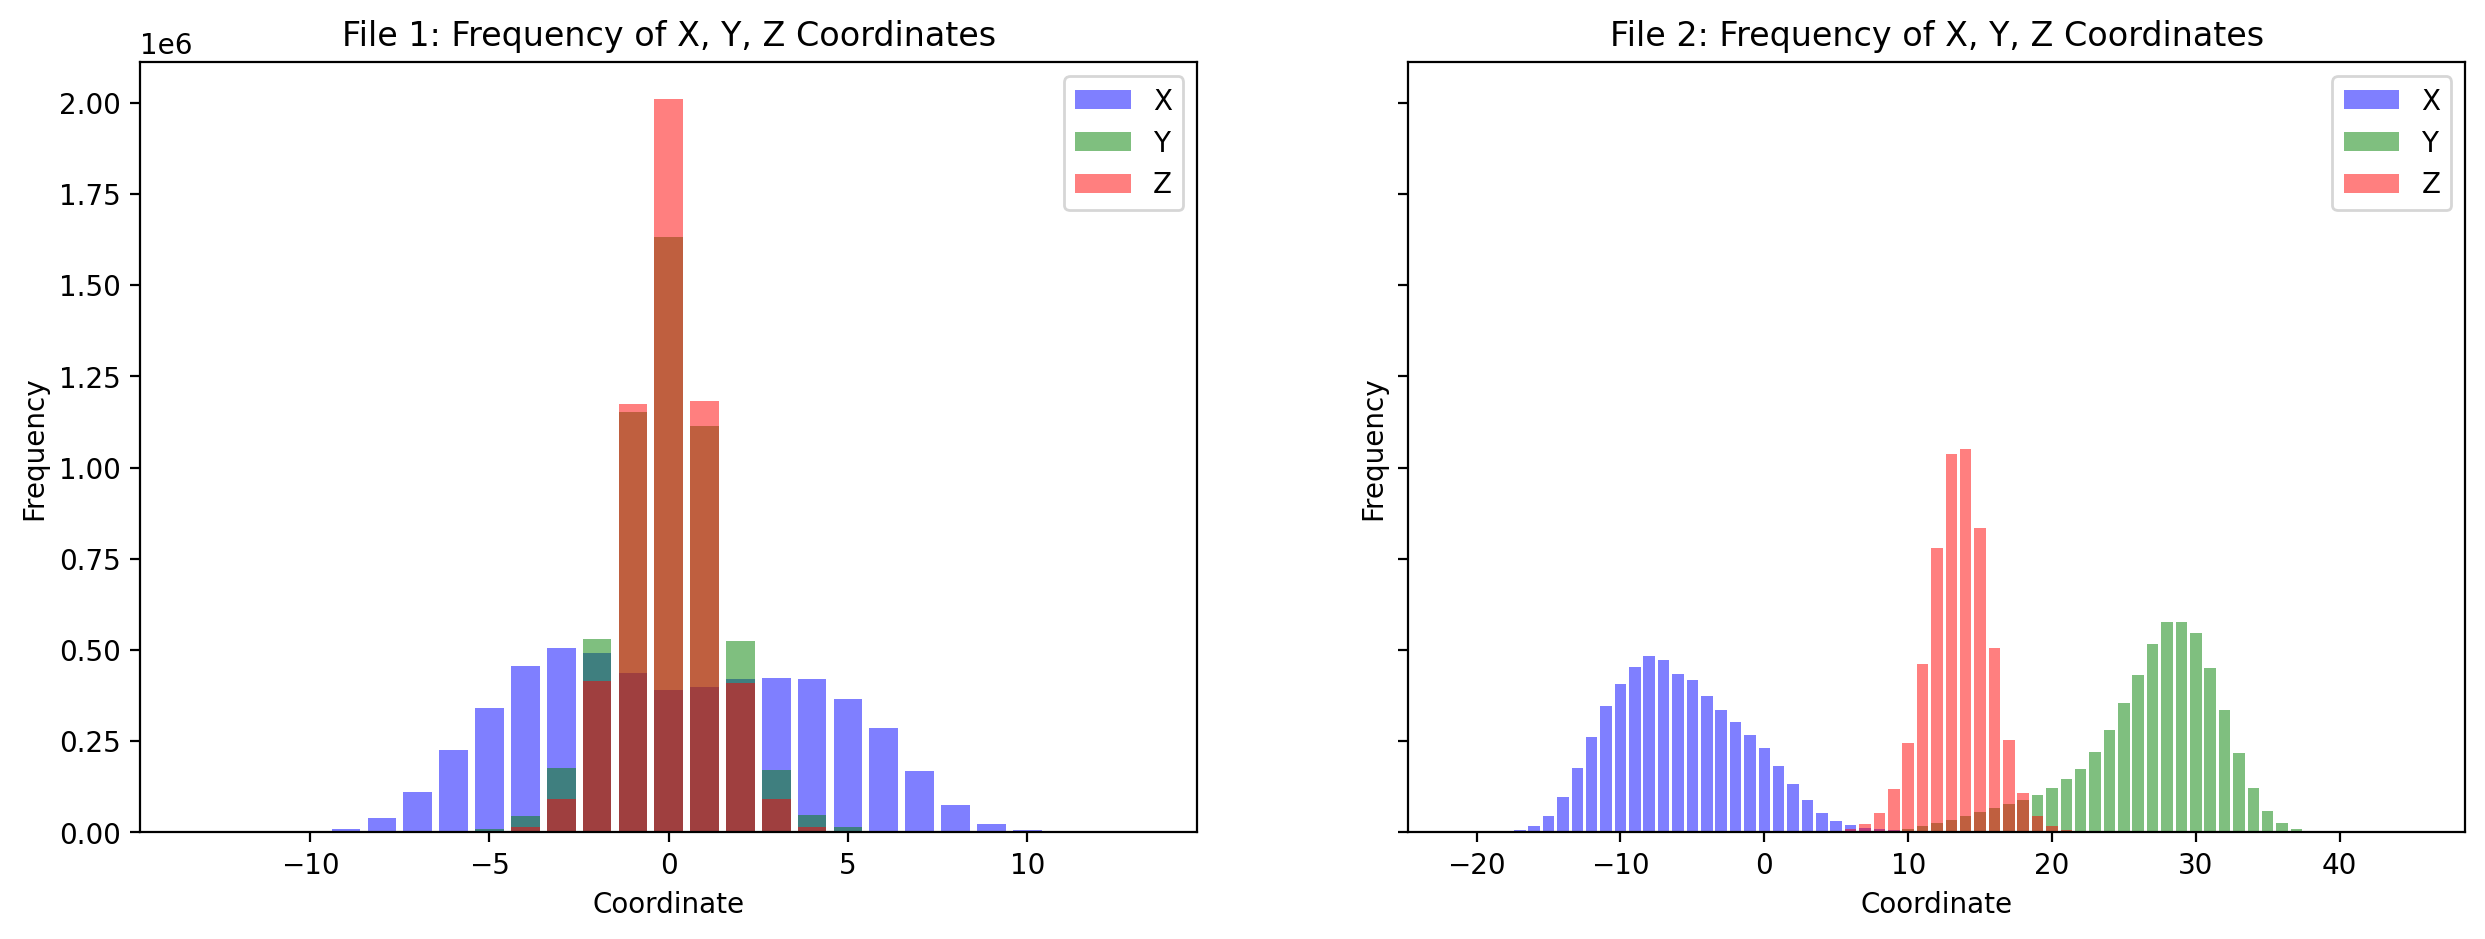

In [11]:
plot_sdf_files(sdf_file1, sdf_file2)

-------------
### Scoring and Ranking of Ligand Positions Using SMINA
While the Equibind model is able to generate predicted positions for any molecule it is presented with, it lacks the ability to rank or score these positions in terms of their binding affinity to the target protein. To overcome this limitation, I turned to the discussions by the author on the Github repository's issue section, where the use of SMINA was suggested to score a series of molecules.

SMINA is a freely available software for molecular docking and scoring, designed for high-performance energy minimization and scoring of protein-ligand complexes. SMINA has been widely used in the field of drug discovery and virtual screening, offering a customizable scoring function and an efficient search algorithm.

Given the time-consuming nature of the scoring process, I opted to use a random sample of 1000 molecules from the model output file. This allowed me to obtain a representative sampling of the data while keeping computational time manageable. To streamline the scoring process, I created custom Python functions that interact with the SMINA binary file installed via mamba. These functions handle the necessary file input/output operations and perform the actual docking and scoring tasks using the SMINA executable.

In [12]:
# Convert the RAS protein to the required pdbqt file
!obabel data/ras/ras_protein.pdb -O data/ras/ras_protein.pdbqt -xr

# Create directories used in my functions
!mkdir -p data/temp data/ligs

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.
1 molecule converted


In [13]:
def extract_best_score(output):
    """
    Extracts the best docking score from the output of the smina program.

    Args:
        output (str): The output of the smina program as a string.

    Returns:
        float or None: The best docking score as a float if found in the output, or None if not found.
    """
    pattern = re.compile(r"^\s*1\s+(-?\d+\.\d+)", re.MULTILINE)
    match = pattern.search(output)
    if match:
        return float(match.group(1))
    return None

def perform_docking(i, mol):
    """
    Performs docking of a ligand molecule to a protein receptor using the smina program.

    Args:
        i (int): The index of the ligand molecule.
        mol (rdkit.Chem.rdchem.Mol): The ligand molecule as an RDKit Mol object.

    Returns:
        tuple or None: A tuple containing the index of the ligand molecule and its best docking score,
        or None if the best docking score was not found in the output.
    """
    mol_file = f"data/ligs/ligand_{i}.sdf"
    writer = SDWriter(mol_file)
    writer.write(mol)
    writer.close()

    output_file = f"data/temp/docking_results_{i}.sdf"

    cmd = f"smina -r {receptor_file} -l {mol_file} --center_x {center_x} --center_y {center_y} --center_z {center_z} --size_x {size_x} --size_y {size_y} --size_z {size_z} -o {output_file}"
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, text=True)

    best_score = extract_best_score(result.stdout)
    if best_score is not None:
        return (i, best_score)
    return None

# Create an SDMolSupplier object to read molecules from an SDF file
sdf_supplier = SDMolSupplier(sdf_file2)

# Define the receptor file and docking box parameters
receptor_file = "data/ras/ras_protein.pdbqt"
center_x, center_y, center_z = 0, 0, 0
size_x, size_y, size_z = 30, 30, 30

# Read all molecules from the SDF file and sample 1000 random molecules
molecules = list(sdf_supplier)
random.seed(123)
sampled_molecules = random.sample(molecules, 1000)

# Perform docking calculations for the sampled molecules in parallel using a thread pool
scores = []
with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
    futures = [executor.submit(perform_docking, i, mol) for i, mol in enumerate(sampled_molecules)]
    for future in futures:
        score = future.result()
        if score is not None:
            scores.append(score)

# Sort the docking scores and select the top 20
sorted_scores = sorted(scores, key=lambda x: x[1])[:20]

# Convert the sorted_scores list to a pandas DataFrame
score_df = pd.DataFrame(sorted_scores, columns=['Molecule index', 'Score'])
docking_scores = [score for _, score in scores]

# Display the DataFrame
score_df

[13:50:55] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


,Molecule index,Score
0,282,-4.7
1,844,-4.6
2,671,-4.5
3,27,-4.4
4,253,-4.4
5,425,-4.4
6,446,-4.4
7,505,-4.4
8,519,-4.4
9,745,-4.4


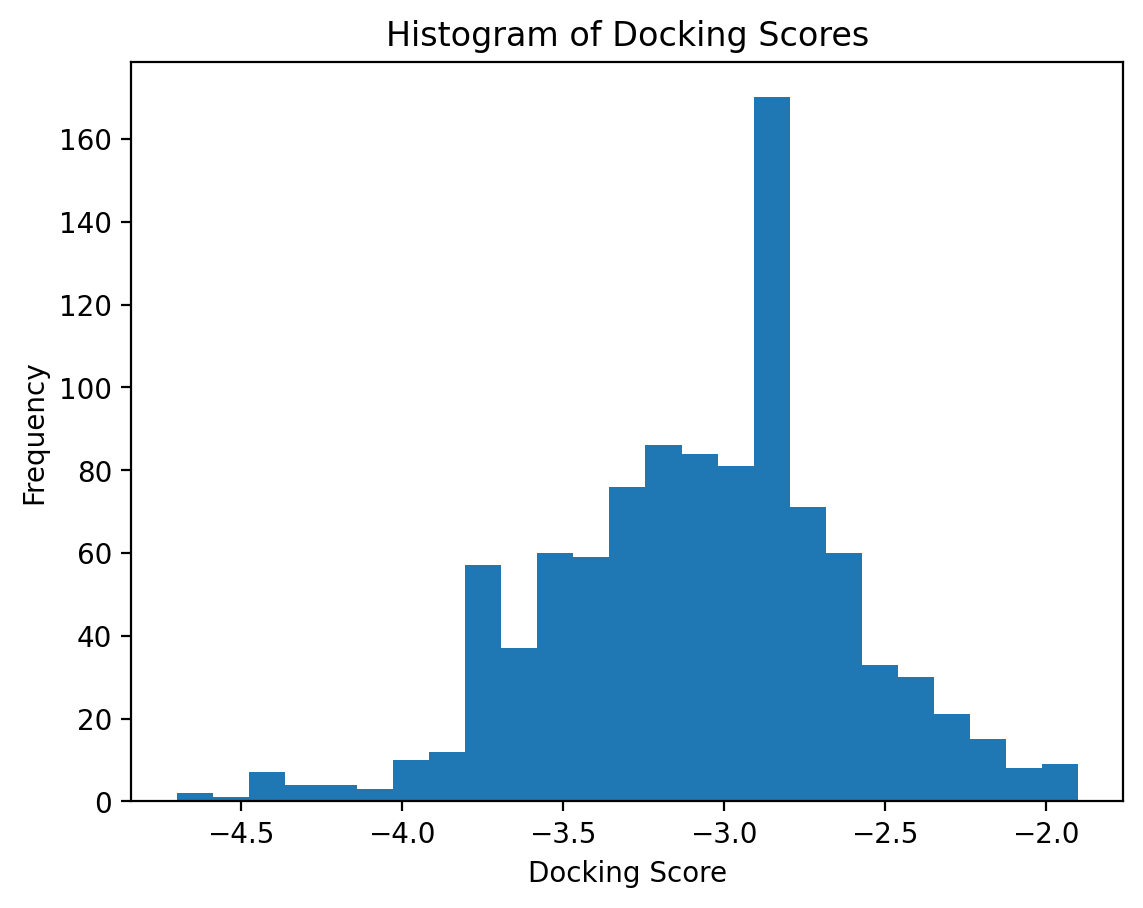

In [14]:
# Generate plot of all scores
plt.hist(docking_scores, bins=25)
plt.xlabel('Docking Score')
plt.ylabel('Frequency')
plt.title('Histogram of Docking Scores')
plt.show()

------------
#### Visual Inspection of Top-Ranking Molecules

After utilizing SMINA to score the binding affinities of the sampled molecules, I proceeded to analyze the top-ranking molecules to better understand their structural characteristics and potential interactions with the target protein. Visual inspection of these high-scoring ligands can provide valuable insights into the binding modes and molecular features that contribute to their predicted binding affinities.

In [15]:
# Load protein data
with open('data/ras/ras_protein.pdb', 'r') as f:
    chA_data = f.read()

# Load ligand data
ligands = []
for i in [282, 309, 884, 214]:
    with open(f'data/temp/docking_results_{i}.sdf', 'r') as f:
        ligands.append(f.read())

view = py3Dmol.view(width=1000, height=1000, viewergrid=(2, 2), linked=False)
view.setViewStyle({'style': 'outline', 'color': 'black', 'width': 0.1})

for i, ligand in enumerate(ligands):
    viewer = (i // 2, i % 2)
    view.addModel(chA_data, 'pdb', viewer=viewer)
    view.addModel(ligand, 'sdf', viewer=viewer)

    chA = {'model': 0}
    chB = {'model': 1}
    
    view.setStyle(chA, {'cartoon': {'color': 'spectrum'}}, viewer=viewer)
    view.addSurface(py3Dmol.VDW, {'opacity': 0.5, 'color': 'white'}, chA, viewer=viewer)
    view.setStyle(chB, {'stick': {}}, viewer=viewer)

    view.zoomTo(viewer=viewer)

view.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### Highest Affinity Ligand

In [16]:
# Load protein data
with open('data/ras/ras_protein.pdb', 'r') as f:
    chA_data = f.read()

# Load ligand data
ligands = []
for i in [282]:  # Changed to only include the ligand with index 282
    with open(f'data/temp/docking_results_{i}.sdf', 'r') as f:
        ligands.append(f.read())

view = py3Dmol.view(width=1000, height=1000, viewergrid=(1, 1), linked=False)  # Changed viewergrid to (1, 1)
view.setViewStyle({'style': 'outline', 'color': 'black', 'width': 0.1})

for i, ligand in enumerate(ligands):
    viewer = (0, 0)  # Changed to a single viewer (0, 0)
    view.addModel(chA_data, 'pdb', viewer=viewer)
    view.addModel(ligand, 'sdf', viewer=viewer)

    chA = {'model': 0}
    chB = {'model': 1}
    
    view.setStyle(chA, {'cartoon': {'color': 'spectrum'}}, viewer=viewer)
    view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'color': 'white'}, chA, viewer=viewer)
    view.setStyle(chB, {'stick': {}}, viewer=viewer)

    view.zoomTo(viewer=viewer)

view.render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol